In [1]:
import torch
import os
from pathlib import Path
from networks.mrnet import MRFactory
from datasets.sampler import make_grid_coords
import yaml
from yaml.loader import SafeLoader
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from datasets.utils import output_on_batched_points, ycbcr_to_rgb
import trimesh

In [2]:
os.environ["WANDB_NOTEBOOK_NAME"] = "eval-net.ipynb"
BASE_DIR = Path('.').absolute().parents[0]
MESH_PATH = BASE_DIR.joinpath('meshes')
MODEL_PATH = BASE_DIR.joinpath('models')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
#filename = "MGmarbl_1-1_w16F_hf20481024_MEp250_hl1_r128_pr2.pth"
filename = "MGmarbl_5-5_w96F_hf2048512_MEp5_hl1_r512_pr2.pth"
mrmodel = MRFactory.load_state_dict(os.path.join(MODEL_PATH, filename))
print("Model: ", type(mrmodel))
print("MODEL TOTAL = ", mrmodel.total_parameters())

MNet(
  (stages): ModuleList(
    (0): MRModule(
      (first_layer): SineLayer(
        (linear): Linear(in_features=3, out_features=256, bias=True)
      )
      (middle_layers): Sequential(
        (0): SineLayer(
          (linear): Linear(in_features=256, out_features=256, bias=True)
        )
      )
      (final_linear): Linear(in_features=256, out_features=3, bias=True)
    )
  )
)
Model:  <class 'networks.mrnet.MNet'>
MODEL TOTAL =  3832842


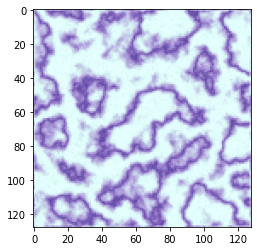

In [7]:
res = 128
# 2D slice for visualization(res**2, 3)
slice = make_grid_coords(res, -1, 1, 3, False)[1].view(-1, 3)
mrmodel.to(device)
with torch.no_grad():
    output = mrmodel(slice.to(device))['model_out']
    img = ycbcr_to_rgb(output.cpu().reshape(res, res, 3)).clamp(0, 1)
plt.imshow(img)

In [5]:
mesh = trimesh.load_mesh(os.path.join(MESH_PATH, 'cube.ply'))
points = torch.from_numpy(mesh.vertices).float()
points = points - points.mean(dim=0)
points = points / points.abs().max()
with torch.no_grad():
    colors = output_on_batched_points(mrmodel, 
                                    points, 
                                    batch_size=512**2, 
                                    device=device).cpu()

In [6]:
mesh.visual.vertex_colors = (ycbcr_to_rgb(colors).clamp(0, 1).numpy() * 255).astype(np.uint8)
mesh.export(os.path.join(MESH_PATH, "textured.ply"))

b'ply\nformat binary_little_endian 1.0\ncomment https://github.com/mikedh/trimesh\nelement vertex 24578\nproperty float x\nproperty float y\nproperty float z\nproperty uchar red\nproperty uchar green\nproperty uchar blue\nproperty uchar alpha\nelement face 49152\nproperty list uchar int vertex_indices\nend_header\n\x00\x00\x80\xbf\x00\x00\x80\xbf\x00\x00\x80?\xb9\xb6\xe4\xff\x00\x00\x80?\x00\x00\x80\xbf\x00\x00\x80?\xb9\xb6\xe4\xff\x00\x00\x80?\x00\x00\x80?\x00\x00\x80?\xb9\xb6\xe4\xff\x00\x00\x80\xbf\x00\x00\x80?\x00\x00\x80?\xb9\xb6\xe4\xff\x00\x00\x80\xbf\x00\x00\x80\xbf\x00\x00\x80\xbf\xb9\xb6\xe4\xff\x00\x00\x80?\x00\x00\x80\xbf\x00\x00\x80\xbf\xb9\xb6\xe4\xff\x00\x00\x80?\x00\x00\x80?\x00\x00\x80\xbf\xb9\xb6\xe4\xff\x00\x00\x80\xbf\x00\x00\x80?\x00\x00\x80\xbf\xb9\xb6\xe4\xff\x00\x00\x00\x00\x00\x00\x80\xbf\x00\x00\x80?\xd3\xe1\xf6\xff\x00\x00\x80?\x00\x00\x00\x00\x00\x00\x80?\xce\xde\xf1\xff\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x80?\x9b\x96\xd0\xff\x00\x00\x00\x00\x00\x00\x80